# • R's Fable/HTS Replication1

<a href="https://colab.research.google.com/github/Nixtla/hierarchicalforecast/blob/main/nbs/examples/AustralianDomesticTourism.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In many cases, only the time series at the lowest level of the hierarchies (bottom time series) are available. `HierarchicalForecast` has tools to create time series for all hierarchies. In this notebook we will see how to do it.

In [1]:

# compute base forecast no coherent
from statsforecast.core import StatsForecast
from statsforecast.models import AutoARIMA, Naive
import pandas as pd

#obtain hierarchical reconciliation methods and evaluation
from hierarchicalforecast.core import HierarchicalReconciliation
from hierarchicalforecast.methods import BottomUp, TopDown, MiddleOut
from datasetsforecast.hierarchical import HierarchicalData
import numpy as np
from statsforecast.models import ETS


/home/arindam/anaconda3/envs/kdd23/lib/python3.9/site-packages/statsforecast/core.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm


## Aggregate bottom time series

In this example we will use the [Tourism](https://otexts.com/fpp3/tourism.html) dataset from the [Forecasting: Principles and Practice](https://otexts.com/fpp3/) book. The dataset only contains the time series at the lowest level, so we need to create the time series for all hierarchies.

In [2]:
# Load TourismSmall dataset
Y_df, S, tags = HierarchicalData.load('./data', 'Traffic')
Y_df['ds'] = pd.to_datetime(Y_df['ds'])

In [3]:
Y_df

,unique_id,ds,y
0,Total,2008-01-01,1536.0182
1,Total,2008-01-02,1619.2435
2,Total,2008-01-03,1423.6574
3,Total,2008-01-04,1096.3325
4,Total,2008-01-05,974.5526
...,...,...,...
75757,Bottom200,2008-12-27,13.0458
75758,Bottom200,2008-12-28,11.6035
75759,Bottom200,2008-12-29,13.4012
75760,Bottom200,2008-12-30,13.3731


In [4]:
S

,Bottom1,Bottom2,Bottom3,Bottom4,Bottom5,Bottom6,Bottom7,Bottom8,Bottom9,Bottom10,...,Bottom191,Bottom192,Bottom193,Bottom194,Bottom195,Bottom196,Bottom197,Bottom198,Bottom199,Bottom200
Total,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
y1,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
y2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
y11,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
y12,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Bottom196,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
Bottom197,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
Bottom198,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
Bottom199,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [5]:
tags

{'Level1': array(['Total'], dtype=object),
 'Level2': array(['y1', 'y2'], dtype=object),
 'Level3': array(['y11', 'y12', 'y21', 'y22'], dtype=object),
 'Level4': array(['Bottom1', 'Bottom2', 'Bottom3', 'Bottom4', 'Bottom5', 'Bottom6',
        'Bottom7', 'Bottom8', 'Bottom9', 'Bottom10', 'Bottom11',
        'Bottom12', 'Bottom13', 'Bottom14', 'Bottom15', 'Bottom16',
        'Bottom17', 'Bottom18', 'Bottom19', 'Bottom20', 'Bottom21',
        'Bottom22', 'Bottom23', 'Bottom24', 'Bottom25', 'Bottom26',
        'Bottom27', 'Bottom28', 'Bottom29', 'Bottom30', 'Bottom31',
        'Bottom32', 'Bottom33', 'Bottom34', 'Bottom35', 'Bottom36',
        'Bottom37', 'Bottom38', 'Bottom39', 'Bottom40', 'Bottom41',
        'Bottom42', 'Bottom43', 'Bottom44', 'Bottom45', 'Bottom46',
        'Bottom47', 'Bottom48', 'Bottom49', 'Bottom50', 'Bottom51',
        'Bottom52', 'Bottom53', 'Bottom54', 'Bottom55', 'Bottom56',
        'Bottom57', 'Bottom58', 'Bottom59', 'Bottom60', 'Bottom61',
        'Bottom62', 

### Split Train/Test sets

We use the final horizon as test set.

In [6]:
HORIZON = 7
FREQUENCY = "1D"

In [7]:
Y_test_df = Y_df.groupby('unique_id').tail(HORIZON)
Y_train_df = Y_df.drop(Y_test_df.index)

In [8]:
Y_test_df = Y_test_df.set_index('unique_id')
Y_train_df = Y_train_df.set_index('unique_id')

In [9]:
Y_train_df.groupby('unique_id').size()

unique_id
Bottom1      359
Bottom10     359
Bottom100    359
Bottom101    359
Bottom102    359
            ... 
y11          359
y12          359
y2           359
y21          359
y22          359
Length: 207, dtype: int64

In [10]:
Y_train_df

,ds,y
unique_id,,
Total,2008-01-01,1536.0182
Total,2008-01-02,1619.2435
Total,2008-01-03,1423.6574
Total,2008-01-04,1096.3325
Total,2008-01-05,974.5526
...,...,...
Bottom200,2008-12-20,12.8311
Bottom200,2008-12-21,12.6597
Bottom200,2008-12-22,12.9989


In [11]:
# list(tags["Level1"])
Y_train_df.loc[Y_train_df.index == "Total"].sort_values(by="ds")

,ds,y
unique_id,,
Total,2008-01-01,1536.0182
Total,2008-01-02,1619.2435
Total,2008-01-03,1423.6574
Total,2008-01-04,1096.3325
Total,2008-01-05,974.5526
...,...,...
Total,2008-12-20,1582.2892
Total,2008-12-21,1579.1646
Total,2008-12-22,1656.7450


## Computing base forecasts

The following cell computes the **base forecasts** for each time series in `Y_df` using the `auto_arima` and `naive` models. Observe that `Y_hat_df` contains the forecasts but they are not coherent.

In [12]:
from sklearn.preprocessing import StandardScaler

# Normalize df
class TSStandardScaler:
    def __init__(self) -> None:
        self.scaler = StandardScaler()
        self.ids = []
        self.ts = None

    def _pd2np(self, df):
        X = []
        for k in df.index.unique():
            self.ids.append(k)
            vals_ = df[df.index == k].sort_values(by="ds")["y"]
            ts_ = df[df.index == k].sort_values(by="ds")["ds"]
            X.append(vals_)
        self.ts = ts_
        X = np.array(X)
        return np.transpose(X)

    def _np2pd(self, X):
        df = {"unique_id": [], "ds": [], "y": []}
        for i in range(X.shape[0]):
            vals_ = X[i,:]
            ids_ = [self.ids[i]] * X.shape[1]
            ts_ = self.ts.values
            # print(i, vals_, ids_, ts_)
            df["unique_id"].extend(ids_)
            df["ds"].extend(ts_)
            df["y"].extend(vals_)
        df = pd.DataFrame(df).set_index("unique_id")
        return df

    def fit(self, df):
        self.scaler.fit(self._pd2np(df))
    
    def transform(self, df):
        Y = self.scaler.transform(self._pd2np(df))
        return self._np2pd(np.transpose(Y))

    def inverse_transform(self, df):
        Y = self.scaler.inverse_transform(self._pd2np(df))
        return self._np2pd(np.transpose(Y))
    

scaler = TSStandardScaler()
scaler.fit(Y_train_df)
Y_train_df = scaler.transform(Y_train_df)
Y_test_df = scaler.transform(Y_test_df)

In [13]:
Y_train_df

,ds,y
unique_id,,
Total,2008-01-01,0.056250
Total,2008-01-02,0.411349
Total,2008-01-03,-0.423161
Total,2008-01-04,-1.819762
Total,2008-01-05,-2.339362
...,...,...
Bottom200,2008-12-20,1.574818
Bottom200,2008-12-21,1.519097
Bottom200,2008-12-22,1.629368


In [14]:
Y_test_df

,ds,y
unique_id,,
Total,2008-12-25,-2.073639
Total,2008-12-26,0.174019
Total,2008-12-27,0.354850
Total,2008-12-28,0.189727
Total,2008-12-29,0.851967
...,...,...
Bottom200,2008-12-27,1.644615
Bottom200,2008-12-28,1.175734
Bottom200,2008-12-29,1.760153


In [18]:
from mlforecast import MLForecast
from window_ops.expanding import expanding_mean
from window_ops.rolling import rolling_mean, rolling_std, seasonal_rolling_mean, seasonal_rolling_std
import lightgbm as lgb
from numba import njit

CONTEXT_LEN = 2*HORIZON

models = [
    lgb.LGBMRegressor()
]

@njit
def rolling_mean_custom(x):
    return rolling_mean(x, window_size=CONTEXT_LEN//2)

@njit
def rolling_std_custom(x):
    return rolling_std(x, window_size=CONTEXT_LEN//2)

@njit
def seasonal_rolling_mean_custom(x):
    return seasonal_rolling_mean(x, season_length=1, window_size=CONTEXT_LEN//2)

rolling_feats = {1:  [expanding_mean]}
for lag in range(1, CONTEXT_LEN//2):
    rolling_feats[lag] = [rolling_mean_custom, rolling_std_custom, seasonal_rolling_mean_custom]


fcst = MLForecast(
    models=models,
    freq=FREQUENCY,
    lags=[_ for _ in range(1, CONTEXT_LEN//2)],
    lag_transforms=rolling_feats,
    date_features=['year', 'month', 'day', 'dayofweek', 'quarter', 'week'],
    differences=[1],
)

fcst.fit(Y_train_df, id_col='index', time_col='ds', target_col='y')
Y_hat_df = fcst.predict(horizon=HORIZON)

Bottom11


<AxesSubplot: xlabel='unique_id'>

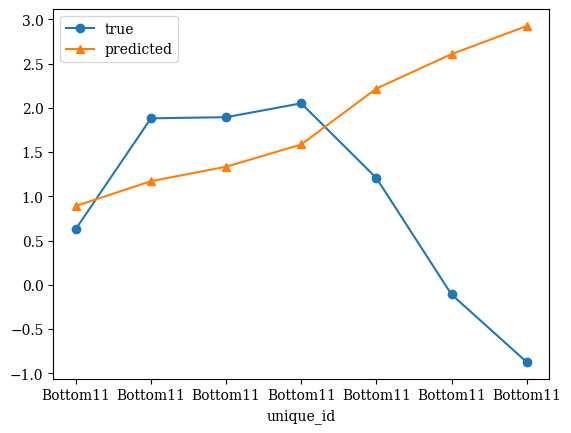

In [23]:
id_ = Y_hat_df.index.unique()[12]
print(id_)
Y_test_df[Y_test_df.index == id_]
Y_test_df[Y_test_df.index == id_]["y"].plot(marker="o", label="true", legend="True")
Y_hat_df[Y_hat_df.index == id_]["LGBMRegressor"].plot(marker="^", label="predicted", legend="Predicted")


### Computing in-sample forecasts needed for MinT, ERM methods
Note that the model is already trained on the training part of the data. Now, the in-sample forecasts are obtained by a moving window method. These in-sample forecasts are needed to estimate the residual covariance matrix in MinT and ERM methods.

In [24]:
dates = Y_df.ds.unique()
dates.sort()
dates_train = Y_train_df.ds.unique()
dates_train.sort()
Y_hat_in_sample = None
for i in range(0, len(dates_train)-HORIZON-CONTEXT_LEN+1):
    # print(i, i+CONTEXT_LEN, i+CONTEXT_LEN+HORIZON)
    backtest_history = Y_train_df[(Y_train_df.ds >= dates[i]) & (Y_train_df.ds < dates[i+CONTEXT_LEN])]
    end_pt = i+CONTEXT_LEN+HORIZON
    if end_pt < len(dates_train):
        backtest_test_true = Y_train_df[(Y_train_df.ds >= dates[i+CONTEXT_LEN]) & (Y_train_df.ds < dates[end_pt])]
    else:
        backtest_test_true = Y_train_df[(Y_train_df.ds >= dates[i+CONTEXT_LEN])]
    
    fcst.fit(backtest_history, id_col='index', time_col='ds', target_col='y')
    Y_hat_in_sample_part = fcst.predict(horizon=HORIZON)
    
    test_dates = backtest_test_true["ds"].unique()
    test_dates.sort()
    first_horizon_date = backtest_test_true["ds"].unique()[0]
    if Y_hat_in_sample is None:
        Y_hat_in_sample = Y_hat_in_sample_part[Y_hat_in_sample_part["ds"] == first_horizon_date]
    else:
        if i == len(dates_train)-HORIZON-CONTEXT_LEN:
            Y_hat_in_sample = pd.concat([Y_hat_in_sample, Y_hat_in_sample_part])
        else:
            Y_hat_in_sample = pd.concat([Y_hat_in_sample, Y_hat_in_sample_part[Y_hat_in_sample_part["ds"] == first_horizon_date]])

In [25]:
Y_hat_in_sample

,ds,LGBMRegressor
unique_id,,
Bottom1,2008-01-15,1.587763
Bottom10,2008-01-15,0.141025
Bottom100,2008-01-15,0.422169
Bottom101,2008-01-15,1.369299
Bottom102,2008-01-15,1.813986
...,...,...
y22,2008-12-20,-3.085833
y22,2008-12-21,-3.563407
y22,2008-12-22,-4.041988


## Denormalize everything

In [26]:
Y_train_df = scaler.inverse_transform(Y_train_df)
Y_test_df = scaler.inverse_transform(Y_test_df)

Y_hat_df["y"] = Y_hat_df["LGBMRegressor"]
Y_hat_df = scaler.inverse_transform(Y_hat_df)
Y_hat_df = Y_hat_df.rename(columns={"y": "LGBMRegressor"})

Y_hat_in_sample = Y_hat_in_sample.rename(columns={"LGBMRegressor": "y"})
Y_hat_in_sample = scaler.inverse_transform(Y_hat_in_sample)
Y_hat_in_sample = Y_hat_in_sample.rename(columns={"y": "LGBMRegressor"})

In [27]:
Y_hat_in_sample

,ds,LGBMRegressor
unique_id,,
Total,2008-01-15,1894.962757
Total,2008-01-16,1757.528226
Total,2008-01-17,1824.071818
Total,2008-01-18,1597.542003
Total,2008-01-19,1341.597402
...,...,...
Bottom200,2008-12-20,-1.505281
Bottom200,2008-12-21,-2.974322
Bottom200,2008-12-22,-4.446461


In [28]:
# Create Y_df with y_hat_in_sample
Y_train_df_extended = Y_train_df.merge(Y_hat_in_sample, on=["ds", "unique_id"], how="inner")
Y_train_df_extended

,ds,y,LGBMRegressor
unique_id,,,
Total,2008-01-15,1754.3192,1894.962757
Total,2008-01-16,1833.1674,1757.528226
Total,2008-01-17,1844.3063,1824.071818
Total,2008-01-18,1276.8030,1597.542003
Total,2008-01-19,1022.8226,1341.597402
...,...,...,...
Bottom200,2008-12-20,12.8311,-1.505281
Bottom200,2008-12-21,12.6597,-2.974322
Bottom200,2008-12-22,12.9989,-4.446461


## Reconcile forecasts

The following cell makes the previous forecasts coherent using the `HierarchicalReconciliation` class. Since the hierarchy structure is not strict, we can't use methods such as `TopDown` or `MiddleOut`. In this example we use `BottomUp` and `MinTrace`.

In [29]:
from hierarchicalforecast.methods import BottomUp, MinTrace, ERM

reconcilers = [
    BottomUp(),
    MinTrace(method='mint_shrink'),
    MinTrace(method='ols'),
    ERM(method='reg')
]
hrec = HierarchicalReconciliation(reconcilers=reconcilers)
Y_rec_df = hrec.reconcile(Y_hat_df=Y_hat_df, Y_df=Y_train_df_extended, S=S, tags=tags)

The dataframe `Y_rec_df` contains the reconciled forecasts.

In [30]:
Y_rec_df

,ds,LGBMRegressor,LGBMRegressor/BottomUp,LGBMRegressor/MinTrace_method-mint_shrink,LGBMRegressor/MinTrace_method-ols,LGBMRegressor/ERM_method-reg_lambda_reg-0.01
unique_id,,,,,,
Total,2008-12-25,1157.265481,1110.301636,1293.680081,1201.360847,115.675644
Total,2008-12-26,1289.097532,1456.661743,1409.098665,1390.313600,1570.453979
Total,2008-12-27,1295.342500,1467.319824,1451.079764,1410.185283,1793.908569
Total,2008-12-28,1366.770897,1503.532837,1527.325193,1474.654687,1637.303467
Total,2008-12-29,1373.941792,1573.784912,1601.769645,1511.493496,1413.111572
...,...,...,...,...,...,...
Bottom200,2008-12-27,4.071926,4.071926,3.075969,4.453826,6.512316
Bottom200,2008-12-28,4.814336,4.814336,4.141231,5.269753,5.073528
Bottom200,2008-12-29,5.372174,5.372174,4.386751,5.641472,0.577846


## Evaluation 

The `HierarchicalForecast` package includes the `HierarchicalEvaluation` class to evaluate the different hierarchies and also is capable of compute scaled metrics compared to a benchmark model.

In [32]:
from hierarchicalforecast.evaluation import HierarchicalEvaluation

def rmse(y, y_hat):
    return np.mean(np.sqrt(np.mean((y-y_hat)**2, axis=1)))

def mase(y, y_hat, y_insample, seasonality=4):
    errors = np.mean(np.abs(y - y_hat), axis=1)
    scale = np.mean(np.abs(y_insample[:, seasonality:] - y_insample[:, :-seasonality]), axis=1)
    return np.mean(errors / scale)

def rmsse(y, y_hat, y_insample):
    errors = np.mean(np.square(y - y_hat), axis=1)
    scale = np.mean(np.square(y_insample[:, 1:] - y_insample[:, :-1]), axis=1)
    return np.mean(np.sqrt(errors / scale))

eval_tags = {}
for k in tags.keys():
    eval_tags[k] = tags[k]

evaluator = HierarchicalEvaluation(evaluators=[rmse, mase, rmsse])
evaluation = evaluator.evaluate(
        Y_hat_df=Y_rec_df, Y_test_df=Y_test_df,
        tags=eval_tags, Y_df=Y_train_df
)
evaluation = evaluation.drop('Overall')
# evaluation.columns = ['Base', 'BottomUp', 'MinTrace(mint_shrink)', 'MinTrace(ols)']
evaluation.columns = ['Base', 'BottomUp', 'MinTrace(ols)', 'MinTrace(mint_shrink)', 'ERM']
evaluation = evaluation.applymap('{:.4f}'.format)

/tmp/ipykernel_3495878/3617059200.py:25: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  evaluation = evaluation.drop('Overall')


### RMSE

The following table shows the performance measured using RMSE across levels for each reconciliation method.

In [33]:
score_df = evaluation.query('metric == "rmse"')
score_df

,,Base,BottomUp,MinTrace(ols),MinTrace(mint_shrink),ERM
level,metric,,,,,
Level1,rmse,270.3549,191.1742,226.0056,184.6785,695.8520
Level2,rmse,100.3015,98.5215,120.3149,102.2161,357.2049
Level3,rmse,39.0970,51.7801,62.2114,53.6974,181.7162
Level4,rmse,3.3854,3.3854,3.4952,3.4484,5.8541


### MASE


The following table shows the performance measured using MASE across levels for each reconciliation method.

In [34]:
evaluation.query('metric == "mase"')

,,Base,BottomUp,MinTrace(ols),MinTrace(mint_shrink),ERM
level,metric,,,,,
Level1,mase,0.7102,0.4712,0.5376,0.5225,1.5220
Level2,mase,0.4167,0.4741,0.5682,0.5506,1.6641
Level3,mase,0.3825,0.4958,0.5683,0.5550,1.7223
Level4,mase,1.4222,1.4222,1.4393,1.4475,2.5722


### RMSSE

In [35]:
score_df = evaluation.query('metric == "rmsse"')
score_df

,,Base,BottomUp,MinTrace(ols),MinTrace(mint_shrink),ERM
level,metric,,,,,
Level1,rmsse,1.0042,0.7101,0.8395,0.6860,2.5847
Level2,rmsse,0.7371,0.7315,0.8854,0.7563,2.6322
Level3,rmsse,0.5796,0.7655,0.9081,0.7947,2.6364
Level4,rmsse,1.6440,1.6440,1.7162,1.6920,2.9081


In [36]:
score_df.astype(float).mean()

Base                     0.991225
BottomUp                 0.962775
MinTrace(ols)            1.087300
MinTrace(mint_shrink)    0.982250
ERM                      2.690350
dtype: float64

### Comparison fable

Observe that we can recover the results reported by the [Forecasting: Principles and Practice](https://otexts.com/fpp3/tourism.html). The original results were calculated using the R package [fable](https://github.com/tidyverts/fable).

![Fable's reconciliation results](./imgs/AustralianDomesticTourism-results-fable.png)

### References
- [Hyndman, R.J., & Athanasopoulos, G. (2021). "Forecasting: principles and practice, 3rd edition: 
Chapter 11: Forecasting hierarchical and grouped series.". OTexts: Melbourne, Australia. OTexts.com/fpp3 
Accessed on July 2022.](https://otexts.com/fpp3/hierarchical.html)
- [Rob Hyndman, Alan Lee, Earo Wang, Shanika Wickramasuriya, and Maintainer Earo Wang (2021). "hts: Hierarchical and Grouped Time Series". URL https://CRAN.R-project.org/package=hts. R package version 0.3.1.](https://cran.r-project.org/web/packages/hts/index.html)
- [Mitchell O’Hara-Wild, Rob Hyndman, Earo Wang, Gabriel Caceres, Tim-Gunnar Hensel, and Timothy Hyndman (2021). "fable: Forecasting Models for Tidy Time Series". URL https://CRAN.R-project.org/package=fable. R package version 6.0.2.](https://CRAN.R-project.org/package=fable)